# Libraries

In [104]:
import pandas as pd
import spacy
import numpy as np
import sys

nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import wordnet
from nltk.corpus import wordnet_ic
nltk.download('wordnet')
nltk.download('wordnet_ic')
ic_brown = wordnet_ic.ic('ic-brown.dat')
from nltk import ngrams
from nltk.metrics import jaccard_distance

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/danimacsai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /home/danimacsai/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


# Features

## Basic Features

In [105]:
def ratio_of_number_of_tokens(tokenized_sentence1, tokenized_sentence2):
    """Given two tokenized sentences, return the ratio of the number of tokens between them"""
    return min(len(tokenized_sentence1), len(tokenized_sentence2))/max(len(tokenized_sentence1), len(tokenized_sentence2))

In [106]:
def ratio_of_number_of_characters(sentence1, sentence2):
    """Given two strings, return the ratio of the number of characters between them"""
    # Dani: same here, I changed this to the ratio instead of the diff
    return min(len(sentence1), len(sentence2)) / max(len(sentence1), len(sentence2))

## Jaccard Similarities

In [107]:
# Tokens
def get_jaccard_similarity(sentence1,sentence2):
    """Returns Jaccard similarity between sentences"""
    return 1-jaccard_distance(set(sentence1), set(sentence2))

## Semantic Features

In [108]:
similarity_methods = {
    "wu-palmer": lambda s1, s2: s1.wup_similarity(s2),
    "path": lambda s1, s2: s1.path_similarity(s2),
    "leacock": lambda s1, s2: s1.lch_similarity(s2),
    "lin": lambda s1, s2: s1.lin_similarity(s2, ic_brown)
}

In [109]:
def get_wordnet_pos(category):
    """
    Convert a POS tag from the Spacy tagset to the WordNet tagset.
    """
    if category.startswith('J'):
        return 'a'  # Adjective
    elif category.startswith('V'):
        return 'v'  # Verb
    elif category.startswith('N'):
        return 'n'  # Noun
    elif (category.startswith('R')) and (category != 'RP'):
        # I looked into the RP tag is for particles
        return 'r'  # Adverb
    else:
        return None  # WordNet doesn't handle other POS tags

In [110]:
cache = {}
def get_best_synset_pair(word1, word2, pos, similarity, similarity_type: str) -> float:
    """
    Get the best synset pair for two words.

    This function gets the best synset pair for two words, considering every possible pair of synsets from the two words. The best pair is the one with the highest similarity score.

    Parameters:
    - word1: The first word, represented as a Spacy token.
    - word2: The second word, represented as a Spacy token.
    - pos: A string indicating the part of speech of the words.
    - similarity: A function to calculate the similarity between two synsets.
    - similarity_type: A string indicating the name of the similarity measure.

    Returns:
    - A float representing the similarity score of the best synset pair.
    """
    # Creating a cache to save time leveraging the symmetry
    cache_key = tuple(sorted([word1.text, word2.text]) + [similarity_type]) 
    if cache_key in cache:
        return cache[cache_key]

    synsets_word1 = wordnet.synsets(word1.text, pos=pos)
    synsets_word2 = wordnet.synsets(word2.text, pos=pos)
    max_sim = 0

    for synset1 in synsets_word1:
        for synset2 in synsets_word2:
            # We skip the satellite adjectives (gives problems for Lin and Leacock)
            if synset1.pos() != 's' and synset2.pos() != 's':
                sim = similarity(synset1, synset2)
                if sim and sim > max_sim:
                    max_sim = sim
    
    cache[cache_key] = max_sim
    # If there is no similarity, we return the default value, 0
    return max_sim

In [111]:
def get_sentence_similarities(sentence1, sentence2, similarity_type: str) -> float:
    """
    Calculate the similarity between two sentences using a specified similarity measure.

    For each sentence, the function gets the best similarity value for each word considering every posible pair, using words from the other sentence. 
    Then the mean of this similarities is computed over the sentence and the output is the mean similarity of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.
    - similarity_type: A string indicating the type of similarity measure to use. 
        Options include "wu-palmer", "path", "leacock", and "lin".

    Returns:
    - A float representing the average similarity score between the two sentences.
    """
    # TODO: Judge if we want to normalize by the number of words that have a valid POS for WordNet (current implementation)
    

    # Do it for sentence1
    similarity1 = 0
    den = 0 # We will normalize by the number of words that have a valid POS for WordNet
    for token1 in sentence1:
        similarities = np.array([])
        pos1 = get_wordnet_pos(token1.tag_)
        if pos1:
            den +=1
            for token2 in sentence2:
                pos2 = get_wordnet_pos(token2.tag_)
                if pos2 and pos1 == pos2:
                    similarities = np.append(similarities,get_best_synset_pair(token1, token2, pos1, similarity_methods[similarity_type], similarity_type))
            if similarities.size > 0:
                similarity1 += np.max(similarities)
    # We average the similarity (even if they don't get a similarity)
    similarity1 = similarity1 / den

    # Do it for sentence2
    similarity2 = 0
    den = 0 # We will normalize by the number of words that have a valid POS for WordNet
    for token2 in sentence2:
        similarities = np.array([])
        pos2 = get_wordnet_pos(token2.tag_)
        if pos2:
            den +=1
            for token1 in sentence1:
                pos1 = get_wordnet_pos(token1.tag_)
                if pos1 and (pos1 != pos2):
                    continue
                similarities = np.append(similarities, get_best_synset_pair(token1, token2, pos2, similarity_methods[similarity_type], similarity_type))
            if similarities.size > 0:
                similarity2 += np.max(similarities)
    # We average the similarity (even if they don't get a similarity)
    similarity2 = similarity2 / den
    
    return np.mean(np.array([similarity1, similarity2]))

### Wu Palmer

### Lin

Apparently, in wordnet there is another postag, 'r', that stands for satellite adjective. This doesn't cause problems with wu-palmer, probably because they share the same synsets as they say here:

"Adjectives are arranged in clusters containing head synsets and satellite synsets. Each cluster is organized around antonymous pairs (and occasionally antonymous triplets). The antonymous pairs (or triplets) are indicated in the head synsets of a cluster. Most head synsets have one or more satellite synsets, each of which represents a concept that is similar in meaning to the concept represented by the head synset. One way to think of the adjective cluster organization is to visualize a wheel, with a head synset as the hub and satellite synsets as the spokes. Two or more wheels are logically connected via antonymy, which can be thought of as an axle between the wheels." from https://wordnet.princeton.edu/documentation/wngloss7wn

The thing is, for some reason this is not allowed when computing lin_similarity. This could be due to some requirements in the use of information from an annotated corpus. I have tried brown and semcor and none work. I could manually remove this, but I want to know why this happens. It stops with:
"nltk.corpus.reader.wordnet.WordNetError: Computing the least common subsumer requires Synset('autochthonal.s.01') and Synset('whole.a.01') to have the same part of speech."

The mistake says, to compute the least common subsumer it is required to have the same pos tag, but wu-palmer also needs the least common subsummer and it doesn't give any error. I looked into this and there is not information online (some links are broken) and most code snippets don't even consider the 'r' class when they are iterating over synsets. 

In the end, we did not use lin similarity because semcor and brown corpus apparently do not allow the pos tag 'r' and 'a' from adverbs and adjctives.

### Word N-Grams Features

In [112]:
def get_ngram_similarity(sentence1, sentence2, n):
    """
    Calculate the similarity between two sentences using n-grams.

    This function calculates the similarity between two sentences using n-grams. The similarity is calculated as the jaccard similarity between the set of n-grams of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a list of tokens.
    - sentence2: The second sentence, represented as a list of tokens.
    - n: The size of the n-grams to use.

    Returns:
    - A float representing the Jaccard similarity between the two sentences.
    """
    ngrams1 = set([str(x) for x in ngrams(sentence1,n)])
    ngrams2 = set([str(x) for x in ngrams(sentence2,n)])
    # Some sentences have less than n words, so we need to check if the ngrams are empty
    if len(ngrams1) == 0 and len(ngrams2) == 0:
        return 1
    return 1-jaccard_distance(ngrams1,ngrams2)

### Character N-Gram Features

In [113]:
def get_character_ngram_similarity(sentence1: str, sentence2: str, n: int) -> float:
    """
    Calculate the similarity between two sentences using character n-grams.

    This function calculates the similarity between two sentences using character n-grams. The similarity is calculated as the jaccard similarity between the set of n-grams of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a string
    - sentence2: The second sentence, represented as a string.
    - n: The size of the n-grams to use.

    Returns:
    - A float representing the Jaccard similarity between the two sentences.
    """
    ngrams1 = set([str(x) for x in ngrams(sentence1,n)])
    ngrams2 = set([str(x) for x in ngrams(sentence2,n)])

    return 1-jaccard_distance(ngrams1,ngrams2)

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def get_char_ngram_vector_similarity(sentence1: str, sentence2: str, nrange: tuple[int, int]) -> float:
    """
    Calculate the similarity between two sentences using character n-grams.

    This function calculates the similarity between two sentences using character n-grams. 
    The similarity is calculated as the cosine similarity between the vectors of the n-grams of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a string
    - sentence2: The second sentence, represented as a string.
    - nrange: A tuple representing the range of n-grams to use.

    Returns:
    - A float representing the cosine similarity between the two sentences.
    """
    vectorizer = CountVectorizer(analyzer='char', ngram_range=nrange)
    ngrams = vectorizer.fit_transform([sentence1, sentence2])

    # Compute cosine similarity
    return cosine_similarity(ngrams[0], ngrams[1])[0][0]

In [115]:
import Levenshtein
def get_levenstein_ratio(sentence1: str, sentence2: str) -> float:
    """
    Calculate the similarity between two sentences using the Levenshtein ratio.

    This function calculates the similarity between two sentences using the Levenshtein ratio. 
    The similarity is calculated as the ratio of the Levenshtein distance between the two sentences and the sum of the lengths of the two sentences.

    Parameters:
    - sentence1: The first sentence, represented as a string
    - sentence2: The second sentence, represented as a string.

    Returns:
    - A float representing the Levenshtein ratio between the two sentences.
    """
    return Levenshtein.ratio(sentence1, sentence2)

# Function to get all of the features

In [116]:
def get_features (df):

    features = pd.DataFrame()
    for rowindex, row in df.iterrows():
        features.at[rowindex, 'token_ratio'] = ratio_of_number_of_tokens(row['0_nlp'], row['1_nlp'])
        features.at[rowindex, 'char_ratio'] = ratio_of_number_of_characters(row["0_lower"], row["1_lower"])
        features.at[rowindex, 'jaccard_similarity_tokens'] = get_jaccard_similarity([token.text for token in row["0_nlp"]], [token.text for token in row["1_nlp"]])
        features.at[rowindex, 'jaccard_similarity_tokens_no_stops'] = get_jaccard_similarity([token.text for token in row["0_nlp_no_stop"]], [token.text for token in row["1_nlp_no_stop"]])
        features.at[rowindex, 'jaccard_similarity_lemmas'] = get_jaccard_similarity(row["0_lemma"], row["1_lemma"])
        features.at[rowindex, 'jaccard_similarity_lemmas_no_stops'] = get_jaccard_similarity(row["0_lemma_no_stop"], row["1_lemma_no_stop"])
        features.at[rowindex, 'wu-palmer'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "wu-palmer")
        #df.at[rowindex, 'lin'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "lin")
        features.at[rowindex, 'path'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "path")
        df.at[rowindex, 'leacock'] = get_sentence_similarities(row["0_nlp"], row["1_nlp"], "leacock")
        features.at[rowindex, 'bigram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 2)
        features.at[rowindex, 'trigram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 3)
        features.at[rowindex, 'quadgram_similarity'] = get_ngram_similarity(row["0_nlp"], row["1_nlp"], 4)
        features.at[rowindex, 'lemma_bigram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 2)
        features.at[rowindex, 'lemma_trigram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 3)
        features.at[rowindex, 'lemma_quadgram_similarity'] = get_ngram_similarity(row["0_lemma"], row["1_lemma"], 4)
        features.at[rowindex, 'char_bigram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 2)
        features.at[rowindex, 'char_trigram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 3)
        features.at[rowindex, 'char_quadgram_similarity'] = get_character_ngram_similarity(row["0_lower"], row["1_lower"], 4)
        features.at[rowindex, "char_ngram_vector_similarity_2"] = get_char_ngram_vector_similarity(row["0_lower"], row["1_lower"], (2, 2))
        features.at[rowindex, "char_ngram_vector_similarity_3"] = get_char_ngram_vector_similarity(row["0_lower"], row["1_lower"], (3, 3))
        features.at[rowindex, "char_ngram_vector_similarity_4"] = get_char_ngram_vector_similarity(row["0_lower"], row["1_lower"], (4, 4))
        features.at[rowindex, "char_ngram_vector_similarity_5"] = get_char_ngram_vector_similarity(row["0_lower"], row["1_lower"], (5, 5))
        features.at[rowindex, "char_ngram_vector_similarity_2_3"] = get_char_ngram_vector_similarity(row["0_lower"], row["1_lower"], (2, 5))
        features.at[rowindex, "levenstein_ratio"] = get_levenstein_ratio(row["0_lower"], row["1_lower"])
        
    return features

- Added Jaccard
- Tried Removing char_quadgram_similarity, char_trigram_similarity and quadgram_similarity for XGBoost and it improved something the accuracy, but not enough
- Random Forest already performs better without changing anything
- Tried removing the test set for Random Forest in the train dataset
  - Didn't improve in everything
- Trying to pivot the grid search of Random Forest around the best parameters
  - Worse Results -> Will try to add new features
- Adding ngram similarities for lemmas
- Reran everything
  - Performance got worse
- Fixed Leacock, dropped Lin

# XGBoost Training

In [117]:
def preprocessing(sentences):
    """Processes the sentences to get the features"""
    # Words (it may have numbers)
    sentences["0_lower"] = sentences[0].apply(lambda x: ''.join([char.lower() if not char.isdigit() else char for char in x]))
    sentences["1_lower"] = sentences[1].apply(lambda x: ''.join([char.lower() if not char.isdigit() else char for char in x]))

    # Tokens
    sentences["0_nlp"] = sentences["0_lower"].apply(lambda x: nlp(x))
    sentences["1_nlp"] = sentences["1_lower"].apply(lambda x: nlp(x))
    # Filter out stop words
    sentences["0_nlp_no_stop"] = sentences["0_nlp"].apply(lambda x: [token for token in x if not token.is_stop])
    sentences["1_nlp_no_stop"] = sentences["1_nlp"].apply(lambda x: [token for token in x if not token.is_stop])

    # Lemmas
    sentences['0_lemma'] = sentences['0_nlp'].apply(lambda x: [token.lemma for token in x])
    sentences['1_lemma'] = sentences['1_nlp'].apply(lambda x: [token.lemma for token in x])
    # Filter out stop words
    sentences['0_lemma_no_stop'] = sentences['0_nlp_no_stop'].apply(lambda x: [token.lemma for token in x])
    sentences['1_lemma_no_stop'] = sentences['1_nlp_no_stop'].apply(lambda x: [token.lemma for token in x])
    return sentences

In [118]:
# Function to read and clean data, tracking bad line indices
def read_and_clean_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cleaned_lines = []
    bad_line_indices = []
    for i, line in enumerate(lines):
        fields = line.strip().split('\t')
        if len(fields) == 2:
            cleaned_lines.append(fields)
        else:
            print(f"Skipping bad line: {line.strip()}")
            bad_line_indices.append(i)

    return pd.DataFrame(cleaned_lines, columns=[0, 1]), bad_line_indices

In [119]:
# Load the train data
sentences_file_paths = [
    "../Data/Train/train/STS.input.SMTeuroparl.txt",
    "../Data/Train/train/STS.input.MSRvid.txt",
    "../Data/Train/train/STS.input.MSRpar.txt",
    ]
gold_standard_file_paths = [
    "../Data/Train/train/STS.gs.SMTeuroparl.txt",
    "../Data/Train/train/STS.gs.MSRvid.txt",
    "../Data/Train/train/STS.gs.MSRpar.txt",
    ]   

# Read and clean the data files into DataFrames, tracking bad line indices
sentences_list = []
bad_line_indices_list = []
for path in sentences_file_paths:
    df, bad_line_indices = read_and_clean_data(path)
    sentences_list.append(df)
    bad_line_indices_list.append(bad_line_indices)

sentences: pd.DataFrame = pd.concat(sentences_list, ignore_index=True)

gs_list = [pd.read_csv(path, header=None) for path in gold_standard_file_paths]
# Remove the rows that correspond to bad lines
for i, gs in enumerate(gs_list):
    gs = gs.drop(bad_line_indices_list[i])
gs_training: pd.DataFrame = pd.concat(gs_list, ignore_index=True)



sentences = preprocessing(sentences)

## Using Every Feature

In [120]:
features_training = get_features(sentences)

In [122]:
# Data split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_training, gs_training, test_size=0.05, random_state=13)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_leaves': [6, 12, 24],
}

xgb = XGBRegressor()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Testing on the training set
y_pred = grid_search.predict(X_test)
y_test_np = np.array(y_test).reshape(-1) 

# Check if arrays are constant
if np.all(y_test_np == y_test_np[0]):
    print("y_test is constant")
if np.all(y_pred == y_pred[0]):
    print("y_pred is constant")

print(f"The pearson correlation on the reserved data for testing is: {pearsonr(np.array(y_test_np), y_pred)[0]}")

The pearson correlation on the reserved data for testing is: 0.8666938050902262


In [ ]:
# import tarfile

# train_file_path = "../Data/test-gold.tgz"
# extraction_path = "../Data/Test"
# # Open the .tgz file
# with tarfile.open(train_file_path, "r:gz") as tar:
#     # Extract all contents to the specified directory
#     tar.extractall(path=extraction_path)
#     print(f"Extracted all files to '{extraction_path}'")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

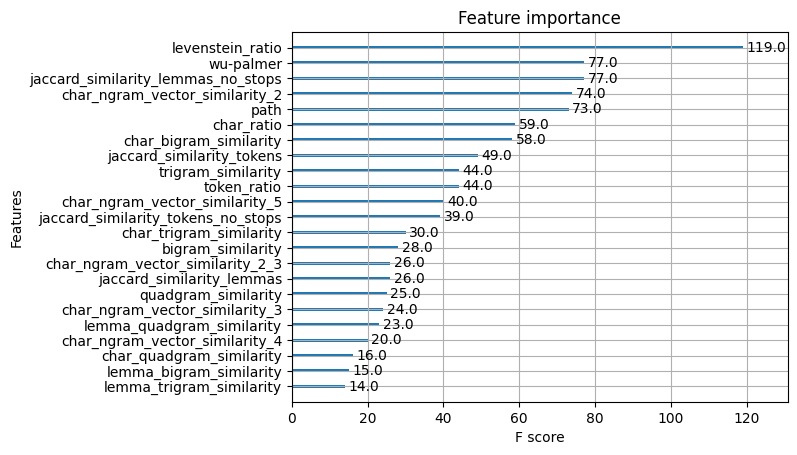

In [123]:
# XGBoost variables importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(grid_search.best_estimator_)

### Testing in SMTeuroparl

In [124]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.SMTeuroparl.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.SMTeuroparl.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

In [125]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.5121141204514741


### Testing on MSRpar

In [126]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.MSRpar.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.MSRpar.txt"

sentences_testing, bad_lines = read_and_clean_data(sentences_testing_file_path)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
gs = gs.drop(bad_lines)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

In [127]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.5342467411860377


### Testing on MSRvid

In [128]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.MSRvid.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.MSRvid.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

In [129]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.8263934604748777


### Testing on Surprise OnWN

In [131]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.surprise.OnWN.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.surprise.OnWN.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

In [132]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.667193936577654


### Testing on Surprise SMTnews

In [133]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.surprise.SMTnews.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.surprise.SMTnews.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

In [134]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.5342784187304073


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Data split
X_train = features_training
y_train = np.ravel(gs_training)

# # Hyperparameter tuning
# from sklearn.ensemble import RandomForestRegressor
# param_grid = {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [ 7, 10, 12, 14],
#     'max_features': [ 'sqrt', 'log2'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# rf = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

grid_search = RandomForestRegressor(max_depth=14, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=600)
y_train = np.ravel(y_train)
grid_search.fit(X_train, y_train)


# print(f"The best parameters are: {grid_search.best_params_}")

RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=600)

In [ ]:
features_importance = pd.DataFrame()
features_importance['feature'] = X_train.columns
features_importance['importance'] = grid_search.feature_importances_
print(features_importance.sort_values(by='importance', ascending=False))

                               feature  importance
14              char_bigram_similarity    0.193754
5   jaccard_similarity_lemmas_no_stops    0.113143
15             char_trigram_similarity    0.103263
3   jaccard_similarity_tokens_no_stops    0.068541
16            char_quadgram_similarity    0.061080
13           lemma_quadgram_similarity    0.058669
7                                 path    0.056123
11             lemma_bigram_similarity    0.043288
10                 quadgram_similarity    0.040106
2            jaccard_similarity_tokens    0.039059
8                    bigram_similarity    0.038140
6                            wu-palmer    0.035239
4            jaccard_similarity_lemmas    0.034365
1                           char_ratio    0.031488
0                          token_ratio    0.030135
9                   trigram_similarity    0.028988
12            lemma_trigram_similarity    0.024618


In [ ]:
gs_testing_list = []
features_testing_list = []

### Testing in SMTeuroparl

In [ ]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.SMTeuroparl.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.SMTeuroparl.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

features_testing_list.append(features_testing)
gs_testing_list.append(gs)

In [ ]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.6118538669369196


### Testing on MSRpar

In [ ]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.MSRpar.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.MSRpar.txt"

sentences_testing, bad_lines = read_and_clean_data(sentences_testing_file_path)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
gs = gs.drop(bad_lines)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

features_testing_list.append(features_testing)
gs_testing_list.append(gs)

In [ ]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.5785253000925605


### Testing on MSRvid

In [ ]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.MSRvid.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.MSRvid.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

features_testing_list.append(features_testing)
gs_testing_list.append(gs)

In [ ]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.820489917872686


### Testing on Surprise OnWN

In [ ]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.surprise.OnWN.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.surprise.OnWN.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

features_testing_list.append(features_testing)
gs_testing_list.append(gs)

In [ ]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)


Pearson correlation on the test set: 0.6891728063703342


### Testing on Surprise SMTnews

In [ ]:
# Testing on the test sets
sentences_testing_standard_file_path = "../Data/Test/test-gold/STS.gs.surprise.SMTnews.txt"
sentences_testing_file_path = "../Data/Test/test-gold/STS.input.surprise.SMTnews.txt"

sentences_testing: pd.DataFrame = pd.read_csv(sentences_testing_file_path ,sep='\t',header=None)
gs: pd.DataFrame = pd.read_csv(sentences_testing_standard_file_path, header=None)
sentences_testing = preprocessing(sentences_testing)
features_testing = get_features(sentences_testing)

features_testing_list.append(features_testing)
gs_testing_list.append(gs)

In [ ]:
# Predict
y_pred_testing = grid_search.predict(features_testing)
y_test_np_testing = np.array(gs).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

Pearson correlation on the test set: 0.5729379215001423


### Testing on all datasets

In [ ]:
features_all = pd.concat(features_testing_list, ignore_index=True)
gs_all = pd.concat(gs_testing_list, ignore_index=True)

# Predict
y_pred_testing = grid_search.predict(features_all)
y_test_np_testing = np.array(gs_all).reshape(-1)

pearson_testing = pearsonr(np.array(y_test_np_testing), y_pred_testing)[0]
print("Pearson correlation on the test set:", pearson_testing)

ValueError: feature_names mismatch: ['token_ratio', 'char_ratio', 'jaccard_similarity_tokens', 'jaccard_similarity_tokens_no_stops', 'jaccard_similarity_lemmas', 'jaccard_similarity_lemmas_no_stops', 'wu-palmer', 'path', 'bigram_similarity', 'trigram_similarity', 'quadgram_similarity', 'lemma_bigram_similarity', 'lemma_trigram_similarity', 'lemma_quadgram_similarity', 'char_bigram_similarity', 'char_trigram_similarity', 'char_quadgram_similarity', 'char_ngram_vector_similarity_2', 'char_ngram_vector_similarity_3', 'char_ngram_vector_similarity_4', 'char_ngram_vector_similarity_5', 'char_ngram_vector_similarity_2_3'] ['token_ratio', 'char_ratio', 'jaccard_similarity_tokens', 'jaccard_similarity_tokens_no_stops', 'jaccard_similarity_lemmas', 'jaccard_similarity_lemmas_no_stops', 'wu-palmer', 'path', 'bigram_similarity', 'trigram_similarity', 'quadgram_similarity', 'lemma_bigram_similarity', 'lemma_trigram_similarity', 'lemma_quadgram_similarity', 'char_bigram_similarity', 'char_trigram_similarity', 'char_quadgram_similarity']
expected char_ngram_vector_similarity_3, char_ngram_vector_similarity_2_3, char_ngram_vector_similarity_2, char_ngram_vector_similarity_5, char_ngram_vector_similarity_4 in input data

https://github.com/nltk/nltk_data/issues/185 : "the information_content() function in wordnet.py is not yet handling adjective satellites. So it is a nltk/nltk issue, because nothing needs to be changed in nltk_data." 